### Summary of the data 
MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

In [11]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
# read the data 
movie_rating=pd.read_csv('ratings.csv')
movie_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [4]:
movie_rating

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [5]:
num_users=movie_rating['userId'].unique().shape[0]
num_movies=movie_rating['movieId'].unique().shape[0]

print(f' num of movies - {num_movies}, num of users {num_users}, movie/user  ratio {int(num_movies/num_users)} ')
print(f' avg rated movies by users -  {round(movie_rating.shape[0]/num_users)}')

 num of movies - 9066, num of users 671, movie/user  ratio 13 
 avg rated movies by users -  149


In [6]:
# in average, ech user have rated 150  movies. This means that we might have get good number of users who watched the same movie - which will help us to
# find similarties 

In [7]:
# we wont use the time stamp : 
movie_rating=movie_rating.drop(['timestamp'], axis=1)

In [8]:
# lets see how to amount of rated movies distrbuted :

# does every user average rate is the same? 
users_average_rate=movie_rating.groupby(by=['userId']).mean().reset_index()
users_average_rate=users_average_rate.rename(columns=
                                             {'rating':'avg_rating'})
users_average_rate=users_average_rate.drop('movieId', axis=1)

Text(0.5, 1.0, 'Rating distribution')

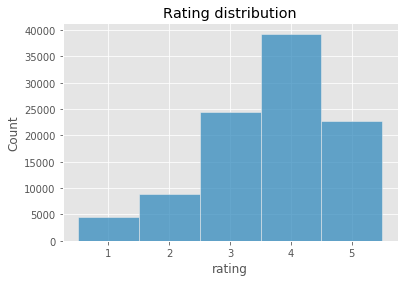

In [9]:
# hist=users_average_rate['avg_rating'].hist()
sns.histplot(data=movie_rating, x="rating", binwidth=1)
plt.title('Rating distribution')

In [10]:
movie_rating

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [49]:
# we can see we have a gaussian like distrubuation of the average
# rating of users. 
# it seems to be a good idea to normalize the rating per user, 
# so it will be more efeective to compare between users preferences 
# so to delete " bias" ratings of users 

In [50]:
# now lets check the spread of movies each user is rating 

min rated number -20, max rated number - 2391 


Text(0.5, 1.0, 'Distrubuation of rating per movie')

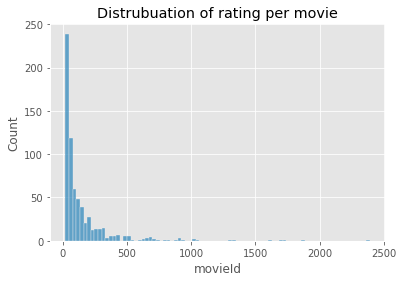

In [51]:
users_count_rated_movies=movie_rating.groupby(by=['userId']).count()
max_num_rated=users_count_rated_movies['movieId'].max()
min_num_rated=users_count_rated_movies['movieId'].min()
print(f'min rated number -{min_num_rated}, max rated number - {max_num_rated} ')

# we have users who only 20 and users who rated up to 2391 movies
# lets look at the distrbution

users_count_rated_movies=users_count_rated_movies.reset_index()
sns.histplot(users_count_rated_movies["movieId"], kde=False);
plt.title('Distrubuation of rating per movie')

(0, 300)

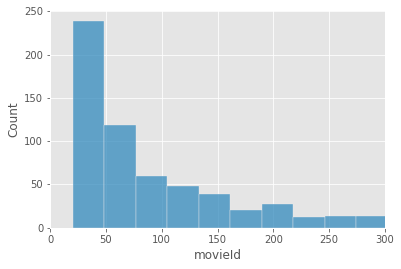

In [52]:
# lets get a close look 
sns.histplot(users_count_rated_movies["movieId"], kde=False);
plt.xlim(0,300)

In [53]:
total=users_count_rated_movies.shape[0]
at_least_50=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<51].shape[0]/total)
at_least_100=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<100].shape[0]/total)
at_least_150=100*(users_count_rated_movies[users_count_rated_movies["movieId"]<150].shape[0]/total)
median=users_count_rated_movies['movieId'].median()
print(f' precentage at least 50- {round(at_least_50)}%,  precentage at least 150- {round(at_least_150)}%, median {median}')

 precentage at least 50- 37%,  precentage at least 150- 73%, median 71.0


In [54]:
# it seems that most usrs rated ~ 100 movies, lets verify it

In [55]:
# lets look on rating per user
users_per_movie

NameError: name 'users_per_movie' is not defined

Text(0.5, 1.0, 'number of rating per movie')

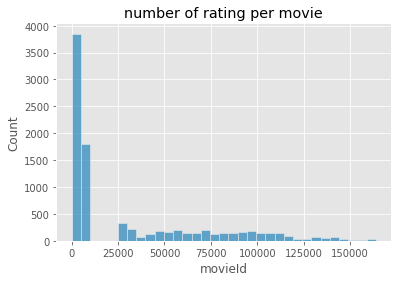

In [56]:
users_per_movie=movie_rating.groupby(by=['movieId']).count().reset_index() # how many users watch a movie
sns.histplot(users_per_movie["movieId"], kde=False);
plt.title('number of rating per movie')

In [57]:
median=users_per_movie['userId'].median()
print('median=',median)

median= 3.0


In [58]:
# most movies has ~ 3 users who watche them
# from this we can duduce that the data is more sutable
# for related 

In [59]:
# to conclude, most users rated  at leastt 70 movies.
# most movies, have 3 useres which rated them. 
# this suggest that user - item base algorithm will work better
# then item item based

In [60]:
# what is the bias: 

average_rating=movie_rating['rating'].mean()
print(f'average_rating={(average_rating)}')

average_rating=3.543608255669773


# Model Training 

In [12]:
import random
import ipynb.fs.full.utilteies as ut # this file includes some function that i build to helo with the model building.


from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline

from surprise.model_selection import cross_validate
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))


In [62]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)

raw_ratings = data.raw_ratings
# shuffle ratings if you want
random.shuffle(raw_ratings)
threshold1 = int(.60 * len(raw_ratings))
threshold2=int(.80 * len(raw_ratings))
train_data = raw_ratings[:threshold1]
chosing_algo_test_data = raw_ratings[threshold1:threshold2]
final_test_data= raw_ratings[threshold2:]
# test_data=
data.raw_ratings = train_data  # data is now the set A
# data_for_opti=data
# data_for_opti.raw_ratings=raw_ratings[:threshold2]
# A = 75% of the data, B = 25% of the data


In [63]:
# chooosing the best algorithm

In [64]:
from surprise import KNNBaseline
sim_options = {'name': 'pearson', 'user_based': True }
pear = KNNBaseline(sim_options=sim_options)

sim_options = {'name': 'cosine', 'user_based': True}
cos = KNNBaseline(sim_options=sim_options)

svd=SVD()
trainset = data.build_full_trainset()
score_dic={'RMSE':'n','F1_score':'n'}
total_score={}
for algo_name, algo in {'PEAR':pear,'COS':cos,'SVD':svd }.items():
    algo.fit(trainset)
    
    # Compute unbiased accuracy 
    chosing_algo = data.construct_testset(chosing_algo_test_data)  # testset is now the set B
    predictions = algo.test(chosing_algo)
    rmse=accuracy.rmse(predictions)
    temp=score_dic.copy()
    temp['RMSE']=rmse
    precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
    temp['F1_score']=f1_score
    total_score[algo_name]=temp

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9261
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9154
RMSE: 0.9091


In [65]:
pd.DataFrame.from_dict(total_score)

,PEAR,COS,SVD
RMSE,0.926082,0.915358,0.909149
F1_score,0.361821,0.361668,0.354465


It seems that both for F1 score and RMSE score, the svd algorithm 
is the best choice.

next step is to optimize the SVD algorithm

# Optimazation of the SVD algorithm

In [66]:
# param_grid = {'n_epochs': [ 20, 30], 
#         'lr_all': [.005, .001, .01, 0.1],'reg_all': [0.2, 0.3]}
# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=4)
# gs.fit(data)



In [67]:
param_grid = {'n_epochs': [  30], 
        'lr_all': [ .01],'reg_all': [0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=4)
gs.fit(data)

In [69]:
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])
algo=gs.best_estimator['rmse']


{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}
0.9035195582362487


In [70]:
# {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}
# 0.9041219469929693


# Final testing of model accuracy

In [71]:
# choosing the best parameters 
algo=gs.best_estimator['rmse']
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)
test = data.construct_testset(final_test_data)  # testset is now the set B
predictions = algo.test(test)
print('Unbiased accuracy ', end=' ')
accuracy.rmse(predictions)
print('Unbiased f1 score ', end=' ')
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f1_score)

Unbiased accuracy  RMSE: 0.8951
Unbiased f1 score  0.3635425907460852


### Training on the entire data set

In [72]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)
trainset = data.build_full_trainset()
algo.fit(trainset)


In [73]:
final_test = data.construct_testset(raw_ratings)
prediction=algo.test(final_test)
accuracy.rmse(predictions)
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k=10, threshold=3.5)
print(f1_score)

RMSE: 0.8951
0.3635425907460852


In [74]:
k=10
precisions, recalls,f1_score = ut.precision_recall_at_k(predictions, k, threshold=3.5)
print(f'pre={precisions}, recall={recalls}, f1_score={f1_score},')

pre=0.7380502250651506, recall=0.7164411785857601, f1_score=0.3635425907460852,


### Building recomandations 

In [75]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [82]:
top_n_df = ut.get_top_n(predictions, n=10)
top_n_df

,UserID,movieID and rating
0,1,"[(5114, 3.5820935059230448), (116, 3.544725141..."
1,2,"[(116, 4.399449333798843), (73290, 4.389560710..."
2,3,"[(5114, 4.303953069105979), (1939, 4.291368980..."
3,4,"[(5114, 4.993751499786199), (73290, 4.97781361..."
4,5,"[(5114, 4.691830198255524), (116, 4.6898979230..."
...,...,...
666,667,"[(5114, 4.4240083936482115), (116, 4.405497500..."
667,668,"[(116, 4.414352143826431), (116897, 4.40799812..."
668,669,"[(73290, 4.378511407891318), (1939, 4.34538552..."
669,670,"[(116, 4.503688631507228), (5114, 4.4945653740..."


In [83]:
top_n_df.loc[0,'movieID and rating']

[(5114, 3.5820935059230448),
 (116, 3.5447251412731604),
 (73290, 3.5285077989337004),
 (8132, 3.5191885334511284),
 (3030, 3.508754037232981),
 (1939, 3.501023345628445),
 (2924, 3.4936716167891304),
 (6273, 3.489055979559997),
 (1948, 3.482299610183072),
 (3038, 3.480965353548157)]

In [77]:
top_n_df.to_csv('recomadation_user.csv')

# Results analysis 
Does check the results makes sense?

lets look on only one the recondation estimation: 

In [62]:
movie_rating

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


In [75]:
movie_rating.sort_values(by='movieId')


,userId,movieId,rating
9713,68,1,4.0
35933,261,1,1.5
52631,383,1,5.0
35983,262,1,2.5
12038,77,1,4.0
...,...,...,...
39546,287,161944,5.0
11823,73,162376,4.5
92339,611,162542,5.0
92340,611,162672,3.0


In [87]:
movie_rating['movieId'].unique().shape

(9066,)

In [40]:
top_n_df = ut.get_top_n(predictions, n=1)
top_n_df.to_csv('recomadation_user_only_one.csv')
top_n_df

,UserID,movieID and rating
0,1,"[(73290, 3.5632048319975036)]"
1,2,"[(5114, 4.4075550532302685)]"
2,3,"[(73290, 4.278589829799506)]"
3,4,"[(5114, 5)]"
4,5,"[(5114, 4.692604014054647)]"
...,...,...
666,667,"[(116, 4.411052752859947)]"
667,668,"[(73290, 4.379869505057912)]"
668,669,"[(116897, 4.355267255175534)]"
669,670,"[(3038, 4.438772594961715)]"


In [41]:
# now lets move to a more coftamble way of dealing with the data 

In [42]:
top_n_df = ut.get_top_n(predictions, n=1)
top_n_df['movieID and rating']=pd.DataFrame(top_n_df['movieID and rating'].tolist())
top_n_df[['movieID','estRating']]=pd.DataFrame(top_n_df['movieID and rating'].tolist())
top_n_df

,UserID,movieID and rating,movieID,estRating
0,1,"(73290, 3.5632048319975036)",73290,3.563205
1,2,"(5114, 4.4075550532302685)",5114,4.407555
2,3,"(73290, 4.278589829799506)",73290,4.278590
3,4,"(5114, 5)",5114,5.000000
4,5,"(5114, 4.692604014054647)",5114,4.692604
...,...,...,...,...
666,667,"(116, 4.411052752859947)",116,4.411053
667,668,"(73290, 4.379869505057912)",73290,4.379870
668,669,"(116897, 4.355267255175534)",116897,4.355267
669,670,"(3038, 4.438772594961715)",3038,4.438773


In [43]:
# lets find out which are the recomanded movies: 
# we saw that there are 18 unique values ! 

In [44]:
top_18_model=list(top_n_df['movieID'].unique())


In [45]:
# now lets see if this data makes sense. 
# we might expect that the best rated movies will be in that list
movies=movie_rating.groupby(['movieId'])
best_movies_by_rating=movie_rating.groupby(['movieId']).mean().reset_index().sort_values('rating',ascending=False)
top_18=best_movies_by_rating.head(18)
top_18_best=list(top_18['movieId'])


In [46]:
list(set(top_18_model).intersection(top_18_best))

[]

In [47]:
# it seems that this is not the case. might be due to the fact that
# those movies were not rated by enough users

# so we might expect that the most rated by users movies will be on the list

In [48]:
# lets look on the movies that was rated by most users  
most_movies_by_users=movie_rating.groupby(['movieId']).count().reset_index().sort_values('rating',ascending=False)
top_18_users=most_movies_by_users.head(18)
top_18_users=list(top_18_users['movieId'])


In [49]:
list(set(top_18_model).intersection(top_18_users))

[318]

In [50]:
# we see that one does appear. 

# lest have another look on the top 18 from the model 

In [98]:
top_18_df_model=movie_rating[movie_rating['movieId'].isin(top_18_model)]
top_18_df_model

,userId,movieId,rating
4,1,1172,4.0
101,3,318,5.0
180,4,858,5.0
370,5,858,2.5
511,7,318,5.0
...,...,...,...
98783,664,858,4.0
99297,665,318,5.0
99802,668,318,4.0
99867,670,318,5.0


No handles with labels found to put in legend.


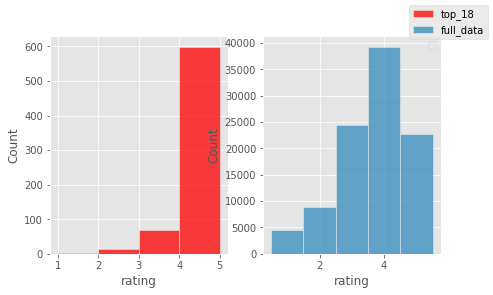

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))


# rating distribution 
sns.histplot(data=top_18_df_model, x="rating", binwidth=1, ax=axs[0],color='red')
# plt.title('Rating distribution, top 18')
plt.legend()

# hist=users_average_rate['avg_rating'].hist()
sns.histplot(data=movie_rating, x="rating", binwidth=1, ax=axs[1])
# plt.title('Rating distribution full data')
fig.legend(labels=['top_18','full_data'])
plt.show()

In [99]:
# we can see that in contrast the the all data behavior, the top 18 rating distrubtion is high
# this makes sense, we would expect the most reconaded to be popular in general
top_18_df_model.groupby(by=['userId']).count()

,movieId,rating
userId,,
1,1,1
3,1,1
4,1,1
5,1,1
7,1,1
...,...,...
664,2,2
665,1,1
668,1,1


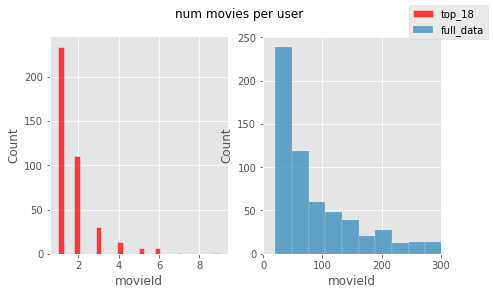

In [113]:
users_count_rated_movies=movie_rating.groupby(by=['userId']).count()
users_count_rated_movies_top_18=top_18_df_model.groupby(by=['userId']).count()

# we have users who only 20 and users who rated up to 2391 movies
# lets look at the distrbution

users_count_rated_movies=users_count_rated_movies.reset_index()
users_count_rated_movies_top_18=users_count_rated_movies_top_18.reset_index()


fig, axs = plt.subplots(1, 2, figsize=(7, 4))

# rating distribution 
sns.histplot(users_count_rated_movies_top_18["movieId"], ax=axs[0],color='red')
ax1=axs[0]
sns.histplot(users_count_rated_movies["movieId"], ax=axs[1])
ax2=axs[1]
ax2.set_xlim((0,300))
fig.suptitle('num movies per user')
fig.legend(labels=['top_18','full_data'])
plt.show()



In [ ]:
# the top 18 distrubution seems quite similar to the distrubution of all data. 

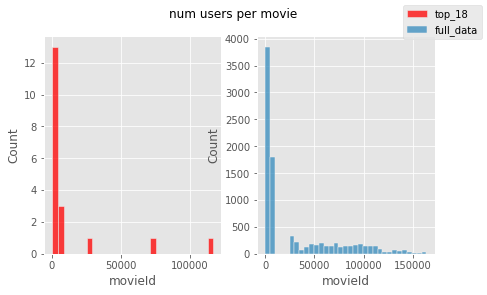

In [131]:
# now lets look on how many users rated a movie:
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
users_per_movie=movie_rating.groupby(by=['movieId']).count().reset_index() # how many users watch a movie
users_per_movie_top_18=top_18_df_model.groupby(by=['movieId']).count().reset_index() # how many users watch a movie

sns.histplot(users_per_movie_top_18['movieId'], ax=axs[0],color='red')
# ax1=axs[0]
sns.histplot(users_per_movie['movieId'], ax=axs[1])
# ax2=axs[1]
# ax2.set_xlim((0,300))
fig.suptitle('num users per movie')
fig.legend(labels=['top_18','full_data'])
plt.show()


In [ ]:
# we can see the top 18 distrubtion is more concetrated around relativly large amount of users who have rated the movie. This leas to similarties between users
# this is something we would expect ! 

# Item similarty
## use case :
suppose that our user is looking on a specif movie on the web,
we would like to recomand him only the movies that are related 
to the movie on the web. meaning we would exclude the non related items from the recomandation list that was based on user similarties. 

In [92]:
movie_rating['movieId'].max()

163949

In [13]:
data = Dataset.load_from_df(movie_rating[['userId', 'movieId', 
                                    'rating']], reader)
raw_ratings = data.raw_ratings
# shuffle ratings if you want
random.shuffle(raw_ratings)
threshold = int(.75 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]
trainset = data.build_full_trainset()


In [14]:
from surprise import get_dataset_dir


In [15]:
from surprise import KNNBaseline
sim_options = {'name': 'cosine', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
# I choose cosine similarty over pearson since we saw that it was better. 

In [ ]:
# now give the user 100 (id) is viewing the movie :6000(id)
# lets get the 10 nearest neighbors 

In [157]:
# loading the recomandation list 
top_n_df=pd.read_csv('recomadation_user.csv',index_col='UserID')
top_n_df

,Unnamed: 0,movieID and rating
UserID,,
1,0,"[(5114, 3.5820935059230448), (116, 3.544725141..."
2,1,"[(116, 4.399449333798843), (73290, 4.389560710..."
3,2,"[(5114, 4.303953069105979), (1939, 4.291368980..."
4,3,"[(5114, 4.993751499786199), (73290, 4.97781361..."
5,4,"[(5114, 4.691830198255524), (116, 4.6898979230..."
...,...,...
667,666,"[(5114, 4.4240083936482115), (116, 4.405497500..."
668,667,"[(116, 4.414352143826431), (116897, 4.40799812..."
669,668,"[(73290, 4.378511407891318), (1939, 4.34538552..."


In [198]:
from ast import literal_eval
def get_user_movie_list(df,userID):
    list_rate_movies_user=list(df.loc[userID,'movieID and rating'])
    rec_movis_u=[i[0] for i in list_rate_movies_user]
    return  rec_movis_u

In [201]:
def top_related_movies(df,userID, movie_raw_id,n=5):
    rec_movis_u=get_user_movie_list(df,userID)
    movie_inner_id=trainset.to_inner_iid(movie_raw_id)
    neighbors=[]
    k=n
    l=0
    while l<n:
        movie_neighbors = algo.get_neighbors(movie_inner_id, k)
        movie_neighbors_raw_id=[trainset.to_raw_iid(i) for i in movie_neighbors]
        l=len(list(set(movie_neighbors_raw_id).intersection(rec_movis_u)))
        k=2*k
    neighbors=list(set(movie_neighbors_raw_id).intersection(rec_movis_u))[:n]
    return neighbors

In [192]:
# loading the recomandation list 
top_n_df=pd.read_csv('recomadation_user.csv',index_col='UserID')
top_n_df['movieID and rating']= top_n_df['movieID and rating'].apply(lambda x: literal_eval(str(x)))
top_n_df



,Unnamed: 0,movieID and rating
UserID,,
1,0,"[(5114, 3.5820935059230448), (116, 3.544725141..."
2,1,"[(116, 4.399449333798843), (73290, 4.389560710..."
3,2,"[(5114, 4.303953069105979), (1939, 4.291368980..."
4,3,"[(5114, 4.993751499786199), (73290, 4.97781361..."
5,4,"[(5114, 4.691830198255524), (116, 4.6898979230..."
...,...,...
667,666,"[(5114, 4.4240083936482115), (116, 4.405497500..."
668,667,"[(116, 4.414352143826431), (116897, 4.40799812..."
669,668,"[(73290, 4.378511407891318), (1939, 4.34538552..."


In [202]:
top_related_movies(top_n_df,userID=100, movie_raw_id=500,n=5)


[116897, 8132, 73290, 7116, 2924]

This is the 5 most related movies from the user - user recomandation list ! 
